# Assignment 3 - Epipolar Geometry and 3D Reconstruction 

First name: Beat  
<br>
Last name: Brändli  
<br>
Matriculation number: 20-163-226  

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import ipyvolume as ipv

from data import load_homogeneous_coordinates
from utils import eight_points_algorithm, right_epipole, plot_epipolar_line, decompose_essential_matrix, infer_3d, ransac

## Part I: The Eight Point Algorithm

### Load Data

In [2]:
data_dir = './merton_college/'
img1, img2, x1, x2 = load_homogeneous_coordinates(data_dir)
print(x1.shape, x2.shape)
x1 = np.float64(x1)
x2 = np.float64(x2)

(3, 344) (3, 344)


### Estimate the fundamental matrix F

In [3]:
F = eight_points_algorithm(x1, x2) 
assert np.linalg.matrix_rank(F) == 2
print('Estimated fundamental matrix: ')
print(F)

Estimated fundamental matrix: 
[[-7.13211234e-09 -2.22444482e-06  9.15976592e-04]
 [ 6.76292458e-06  2.86499507e-07 -2.54211176e-02]
 [-2.81255404e-03  2.38242528e-02  1.00000000e+00]]


In [4]:
# compute the epipole
# TODO: implement this function
e = right_epipole(F)  
print('Epipole: ', e)

Epipole:  [3.74195816e+03 3.99779989e+02 1.00000000e+00]


### Plot epipoles and epipolar lines

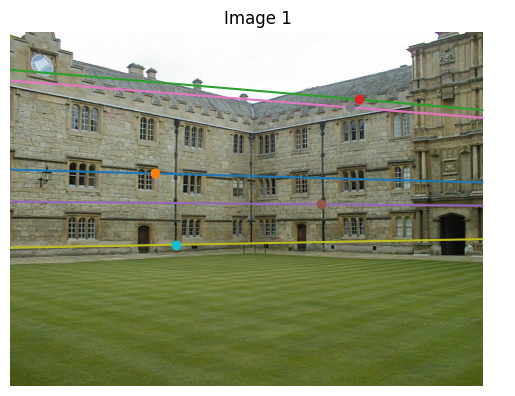

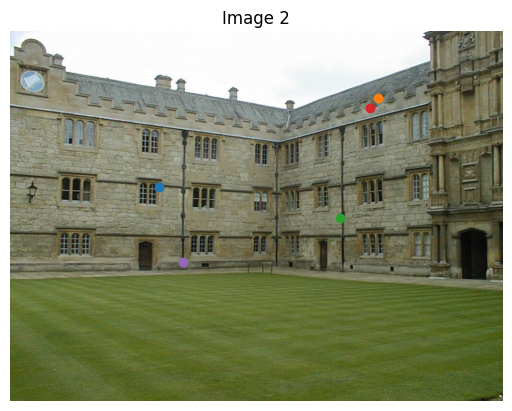

In [5]:
plt.figure()
plt.imshow(img1)
plt.title('Image 1')

# plot each line individually, this gives nice colors
for i in range(100, 105): 
    plot_epipolar_line(img1, F.T, x2[:, i], e)
    plt.plot(x1[0, i], x1[1, i], 'o')

plt.axis('off')
plt.figure()
plt.imshow(img2)
plt.title('Image 2')

# plot each point individually, this gives same colors as the lines 
for i in range(100, 105):
    plt.plot(x2[0, i], x2[1, i], 'o')
    plt.axis('off')

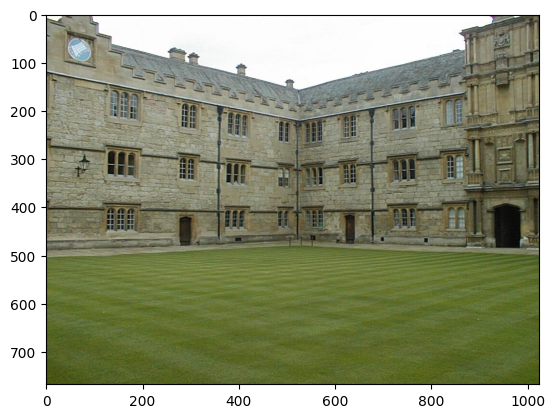

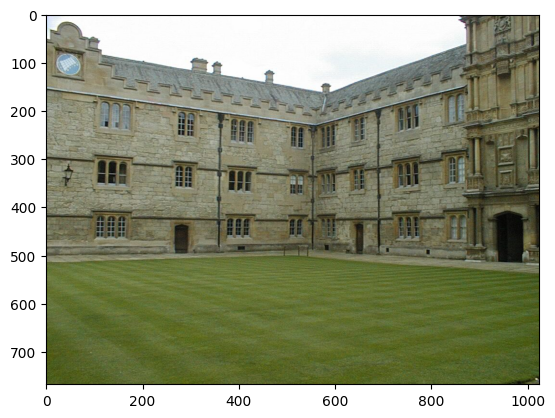

In [6]:
%matplotlib inline
from ipywidgets import *

fig, ax = plt.subplots()
ax.imshow(img1)

fig2, ax2 = plt.subplots()
ax2.imshow(img2)

def onclick(event):
    ax.plot(event.xdata, event.ydata, 'o')
    plot_epipolar_line(img2, F, np.array([event.xdata, event.ydata, 1]), e, ax2)
    ax2.imshow(img2)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

## Part II: 3D Model Reconstruction

### Load matched points
We provide a synthetic pair of images where noisy correspondences are known.

In [7]:
import numpy as np
from PIL import Image
import os

left = np.array(Image.open(os.path.join('MatchedPoints','left.jpg')), dtype=np.float32).mean(2)/255
right = np.array(Image.open(os.path.join('MatchedPoints','right.jpg')), dtype=np.float32).mean(2)/255

Text(0.5, 1.0, 'Right image')

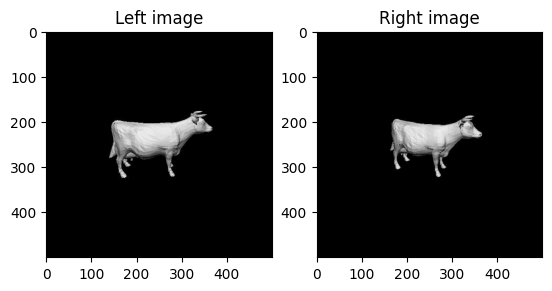

In [8]:
plt.subplot(1,2,1)
plt.imshow(left, cmap='gray')
plt.title('Left image')
plt.subplot(1,2,2)
plt.imshow(right, cmap='gray')
plt.title('Right image')

In [9]:
matriculation_number = 20163226 # TODO
A = np.loadtxt(f'MatchedPoints/Matched_Points_{matriculation_number % 50}.txt')

In [10]:
M, N = A.shape
leftPoints = np.concatenate((A[:,2:4].T, np.ones((1, M))), axis=0)
rightPoints = np.concatenate((A[:,0:2].T, np.ones((1, M))), axis=0)
print(leftPoints.shape)

(3, 12590)


### Calibration matrix and focal length from the given file

In [11]:
fl = 4
K = np.array([
    [-83.33333, 0.00000, 250.00000],
    [0.00000, -83.33333, 250.00000],
    [0.00000, 0.00000,   1.00000],
])

I = K.copy()

I[0,0] *= fl
I[1,1] *= fl

### Estimate Essential matrix E from F with RANSAC

In [12]:
good_threshold = 0.0075
F, inliers = ransac(leftPoints, rightPoints, good_threshold, num_steps=200)
print('Num outliers', leftPoints.shape[1] - inliers.sum())
assert np.linalg.matrix_rank(F) == 2
print('Estimated fundamental matrix: ')
print(F)

# TODO: Estimate essential matrix E from F
# Compute Essential Matrix
E = I.T @ F @ I

U, S, Vt = np.linalg.svd(E)
S = np.diag([1, 1, 0])  # Force singular values to [1, 1, 0]
E = U @ S @ Vt

print('Estimated essential matrix: ')
print(E)

Num outliers 7322
Estimated fundamental matrix: 
[[ 1.56214171e-06 -1.10872606e-06 -1.47745183e-03]
 [ 9.08723213e-06  2.61035595e-07 -1.00733200e-02]
 [-2.40273693e-03  7.47994945e-03  1.00000000e+00]]
Estimated essential matrix: 
[[ 0.06161296 -0.05225315  0.16216354]
 [ 0.35885185  0.00344707  0.91711657]
 [-0.03218106 -0.9981029   0.00648848]]


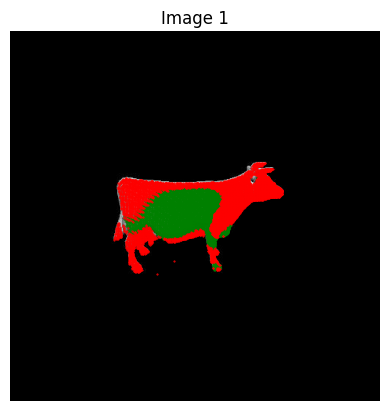

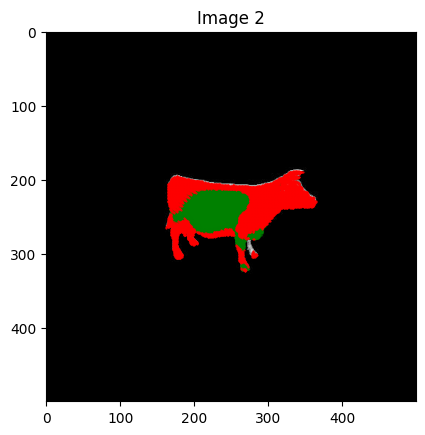

In [13]:
#Draw all the points to see the inliers
plt.figure()

plt.imshow(left, cmap='gray')
plt.title('Image 1')
inlier_r= rightPoints[:, inliers]
inlier_l = leftPoints[:, inliers]
outlier_r = rightPoints[:, ~inliers]
outlier_l = leftPoints[:, ~inliers]
for i in range(0, inliers.sum()): 
    plt.plot(inlier_l[0, i], -inlier_l[1, i]+left.shape[0], 'o', markersize=0.5, color='green')
for i in range(0, (~inliers).sum()):
    plt.plot(outlier_l[0, i], -outlier_l[1, i]+left.shape[0], 'o', markersize=0.5, color='red')




plt.axis('off')
plt.figure()
plt.imshow(right, cmap='gray')
plt.title('Image 2')
for i in range(0, inliers.sum()): 
    #plot_epipolar_line(left, F.T, r[:, i], e)
    plt.plot(inlier_r[0, i], -inlier_r[1, i]+right.shape[0], 'o', markersize=0.5, color='green')
for i in range(0, (~inliers).sum()): 
    plt.plot(outlier_r[0, i], -outlier_r[1, i]+right.shape[0], 'o', markersize=0.5, color='red')

### Compute rotation and translation between views

In [14]:
# TODO: Compute rotation and translation between views. Complete decomposeE
Il = np.linalg.solve(I, leftPoints)
Ir = np.linalg.solve(I, rightPoints)

Pl, Pr = decompose_essential_matrix(E, Il, Ir)

print('Estimated translation: ')
print(Pr[:,3])
print('Estimated rotation: ')
print(Pr[:,:3])

[1.00000000e+00 1.00000000e+00 3.96781102e-17]
(3, 3) (3,)
Estimated translation: 
[ 0.98345129 -0.17352428 -0.05208539]
Estimated rotation: 
[[ 0.9396742   0.14153244 -0.31141767]
 [-0.13307749  0.98992557  0.04835018]
 [ 0.31512344 -0.00399074  0.9490423 ]]


### Estimate the 3D points

In [15]:
x3D = infer_3d(Il, Ir, Pl, Pr)
ipv.quickscatter(x=x3D[0,:], y=x3D[1,:], z=x3D[2,:])

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…